In [1]:
from pyheatmy import *
from typing import List, Sequence, Union
from numbers import Number
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from layers import AllPriors,LayerPriors, Layer, getListParameters
PARAM_LIST = ("moinslog10IntrinK", "n", "lambda_s", "rhos_cs")

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

In [5]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

In [6]:
params = Param(
    moinslog10IntrinK = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

col.compute_solve_transi(params, nb_cells=100)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Solving the flow with intrinsec permeability 0.0001, and permeability 981.0000000000001
Done.


In [7]:
priors_couche_1 = {
    "moinslog10IntrinK": ((1, 10), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_2 = {
    "moinslog10IntrinK": ((4, 9), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_3 = {
    "moinslog10IntrinK": ((4, 9), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

In [8]:
all_priors = [
    ['Couche 1', 0.4, priors_couche_1]
]

In [9]:
#all_priors = [['Couche 1', 0.4, priors_couche_1]] 

In [10]:
def conv(layer):
    name, prof, priors = layer
    if isinstance(priors, dict):
        return (
            name,
            prof,
            [Prior(*args) for args in (priors[lbl] for lbl in PARAM_LIST)],
        )
    else:
        return layer

if not isinstance(all_priors, AllPriors):
    all_priors = AllPriors([LayerPriors(*conv(layer)) for layer in all_priors])

In [20]:
nb_chain = 10
nb_iter = 1000
nb_param = 4
nb_times = len(col._times)
delta = 3
ncr = 3
c = 0.1
c_star=1e-6
nb_cells = 100
#temp_ref = col._T_measures[:, :].T
dz = col._real_z[-1] / nb_cells
_z_solve = dz / 2 + np.array([k * dz for k in range(nb_cells)])
ind_ref = [np.argmin(np.abs(z - _z_solve)) for z in col._real_z[1:-1]]
temp_ref = col.get_temperatures_solve()[ind_ref]
sigma2 = 1
nb_layer = len(all_priors)
col._states = list()

ranges = np.empty((nb_layer, nb_param, 2))
for l in range(nb_layer):
    for p in range(nb_param):
        ranges[l,p] = all_priors[l][p].range  


def compute_energy(temp: np.array):
    norm2 = np.nansum((temp - temp_ref) ** 2)
    return 0.5 * norm2 / sigma2

def compute_log_acceptance(actual_energy: float, prev_energy: float):
    return prev_energy - actual_energy

def convert_to_layer(name_layer, z_low, params): 
    return [Layer(name_layer[i], z_low[i], *params[i]) for i in range(nb_layer)]

def check_range(x, ranges): 
    while np.sum(x < ranges[:,0]) + np.sum(x > ranges[:,1]) > 0:
        x = (x < ranges[:,0]) * (ranges[:,1] - (ranges[:,0] - x)) + (x > ranges[:,1]) * (ranges[:,0] + (x - ranges[:,1])) + (x >= ranges[:,0]) * (x <= ranges[:,1]) * x
    return x

import numpy as np

def gelman_rubin(nb_current_iter, nb_param, nb_layer, chains, threshold=1.1):
    """
    Input : chains [3D np.array] - chaînes de Markov calculées en parallèle
            threshold [float] - seuil de l'indicateur de Gelman-Rubin, légèrement supérieur à 1
    
    Output : [bool] - True si et seulement si la phase de burn-in est considérée finie
    """
    R = np.zeros((nb_layer, nb_param))
    for l in range(nb_layer):   
        chains_layered = chains[:,:,l,:]
        # Variances intra-chaînes des paramètres
        Var_intra = np.var(chains_layered, axis=0)

        # Moyenne des variances intra-chaîne
        var_intra = np.mean(Var_intra, axis=0)

        # Moyennes de chaque chaîne
        means_chains = np.mean(chains_layered, axis=0)

        # Variance entre les moyennes des chaînes, dite inter-chaînes
        var_inter = np.var(means_chains, axis=0)

        # Calcul de l'indicateur de Gelman-Rubin
        for j in range(nb_param):
            if np.isclose(var_intra[j], 0) :
                R[l,j] = 2
            else:
                R[l,j] = np.sqrt( var_inter[j] / var_intra[j] * (nb_current_iter - 1) / nb_current_iter + 1) # Vérifier la formule

    print("R = ", R)

    # On considère que la phase de burn-in est terminée dès que R < threshold
    return np.all(R < threshold)

# initialisation
n_sous_ech_time = 2 # 1 mesure considérée par demi-heure
n_sous_ech_space = 4 # 1 mesure considérée tous les 2 cm
nb_cells_sous_ech = int(np.ceil(nb_cells//n_sous_ech_space))
nb_times_sous_ech = int(np.ceil(nb_times//n_sous_ech_time))
X = np.array([np.array(all_priors.sample()) for _ in range(nb_chain)])
X = np.array([np.array([X[c][l].params for l in range(nb_layer)]) for c in range(nb_chain)])
_params = np.zeros((nb_iter + 1, nb_chain, nb_layer, nb_param))
_params[0] = X
_temp = np.zeros((nb_iter + 1, nb_chain, nb_cells, len(col._times)), np.float32)
_temp_act = np.zeros((nb_chain, nb_cells, nb_times), np.float32)
_temp_sous_ech = np.zeros((nb_iter+1, nb_chain, nb_cells_sous_ech, len(col._times)), np.float32)
_energy = np.zeros((nb_iter + 1, nb_chain))      
temp_new = np.zeros((nb_cells, nb_times))
energy_new = 0

name_layer = [all_priors.sample()[i].name for i in range(nb_layer)]
z_low = [all_priors.sample()[i].zLow for i in range(nb_layer)]

print(_energy.shape,_temp_act.shape,_temp_sous_ech.shape)

(1001, 10) (10, 100, 1309) (1001, 10, 25, 1309)


In [21]:
#initialisation des chaines
for i in range(nb_chain): 
    col.compute_solve_transi(convert_to_layer(name_layer, z_low, X[i]), nb_cells, verbose = False)
    _temp[0][i] = col.get_temperatures_solve()
    _energy[0][i] = compute_energy(_temp[0][i][ind_ref, :])

In [22]:
cr_vec = np.arange(1,ncr+1)/ncr
n_id = np.zeros((nb_layer, ncr))
J = np.zeros((nb_layer, ncr))
pcr = np.ones((nb_layer, ncr))/ncr

In [23]:
nb_burn_in_iter = 0 
threshold = 1.1

for i in range(nb_iter):
    # Initialize arrays for new parameter values
    x_new = np.zeros((nb_layer, nb_param))
    X_new = np.zeros((nb_chain, nb_layer, nb_param))
    std_X = np.std(X, axis=0)
    
    # Loop over chains
    for j in range(nb_chain):
        # Initialize arrays for new parameter values
        dX = np.zeros((nb_layer,nb_param))
        
        # Loop over layers
        for l in range(nb_layer):
            # Select a crossover point
            id = np.random.choice(ncr, p=pcr[l])
            
            # Generate random numbers
            z = np.random.uniform(0, 1, nb_param)
            A = (z <= cr_vec[id])
            d_star = np.sum(A)
            
            # If no parameters are selected, select the smallest one
            if d_star == 0:
                A[np.argmin(z)] = True
                d_star = 1
            
            # Generate random numbers
            lambd = np.random.uniform(-c, c, d_star)
            zeta = np.random.normal(0, c_star, d_star)
            
            # Select chains for difference vectors
            choose = np.delete(np.arange(nb_chain), j)
            a = np.random.choice(choose, delta, replace=False)
            choose = np.delete(choose, np.where(np.isin(a, choose)))
            b = np.random.choice(choose, delta, replace=False)
            
            # Compute difference vectors
            gamma = 2.38 / np.sqrt(2 * d_star * delta)
            dX[l][A] = zeta + (1 + lambd) * gamma * np.sum(X[a,l][:,A] - X[b,l][:,A], axis=0)
            
            # Compute new parameter values
            x_new[l] = X[j,l] + dX[l]
            x_new[l] = check_range(x_new[l], ranges[l])
        
        # Compute new temperature profile and energy
        col.compute_solve_transi(convert_to_layer(name_layer, z_low, x_new), nb_cells, verbose=False)
        temp_new = col.get_temperatures_solve()
        energy_new = compute_energy(temp_new[ind_ref, :])
        
        # Compute acceptance probability
        log_ratio_accept = compute_log_acceptance(energy_new, _energy[i][j])
        
        # Accept or reject new parameter values
        if np.log(np.random.uniform(0, 1)) < log_ratio_accept:
            X_new[j] = x_new
            _temp[i+1][j] = temp_new
            _energy[i+1][j] = energy_new
        else:
            dX = np.zeros((nb_layer, nb_param))
            X_new[j] = X[j]
            _temp[i+1][j] = _temp[i-1][j]
            _energy[i+1][j] = _energy[i-1][j]
        
        # Update J and n_id
        for l in range(nb_layer):
            J[l,id] += np.sum((dX[l] / std_X[l])**2)
            n_id[l,id] += 1
    
    # Update pcr
    for l in range(nb_layer):
        pcr[l] = J[l] / n_id[l]
        pcr[l] = pcr[l] / np.sum(pcr[l])
    
    # Update parameter values
    X = X_new
    _params[i+1] = X_new
    
    # Check for convergence
    if gelman_rubin(i+2, nb_param, nb_layer, _params[:i+2], threshold=threshold):
        print(f"Burn in finished after : {nb_burn_in_iter} iterations")
        break
    nb_burn_in_iter += 1 
    
    
# Burn in finished, parameters are now saved
_params = np.zeros((nb_iter + 1, nb_chain, nb_layer, nb_param))
_params[0] = X
_temp = np.zeros((nb_iter + 1, nb_chain, nb_cells, len(col._times)), np.float32)
_energy = np.zeros((nb_iter + 1, nb_chain))
for i in range(nb_iter):
    # Initialize arrays for new parameter values
    x_new = np.zeros((nb_layer, nb_param))
    X_new = np.zeros((nb_chain, nb_layer, nb_param))
    std_X = np.std(X, axis=0)
    
    # Loop over chains
    for j in range(nb_chain):
        # Initialize arrays for new parameter values
        dX = np.zeros((nb_layer,nb_param))
        
        # Loop over layers
        for l in range(nb_layer):
            # Select a crossover point
            id = np.random.choice(ncr, p=pcr[l])
            
            # Generate random numbers
            z = np.random.uniform(0, 1, nb_param)
            A = (z <= cr_vec[id])
            d_star = np.sum(A)
            
            # If no parameters are selected, select the smallest one
            if d_star == 0:
                A[np.argmin(z)] = True
                d_star = 1
            
            # Generate random numbers
            lambd = np.random.uniform(-c, c, d_star)
            zeta = np.random.normal(0, c_star, d_star)
            
            # Select chains for difference vectors
            choose = np.delete(np.arange(nb_chain), j)
            a = np.random.choice(choose, delta, replace=False)
            choose = np.delete(choose, np.where(np.isin(a, choose)))
            b = np.random.choice(choose, delta, replace=False)
            
            # Compute difference vectors
            gamma = 2.38 / np.sqrt(2 * d_star * delta)
            dX[l][A] = zeta + (1 + lambd) * gamma * np.sum(X[a,l][:,A] - X[b,l][:,A], axis=0)
            
            # Compute new parameter values
            x_new[l] = X[j,l] + dX[l]
            x_new[l] = check_range(x_new[l], ranges[l])
        
        # Compute new temperature profile and energy
        col.compute_solve_transi(convert_to_layer(name_layer, z_low, x_new), nb_cells, verbose=False)
        temp_new = col.get_temperatures_solve()
        energy_new = compute_energy(temp_new[ind_ref, :])
        
        # Compute acceptance probability
        log_ratio_accept = compute_log_acceptance(energy_new, _energy[i][j])
        
        # Accept or reject new parameter values
        if np.log(np.random.uniform(0, 1)) < log_ratio_accept:
            X_new[j] = x_new
            _temp[i+1][j] = temp_new
            _energy[i+1][j] = energy_new
        else:
            dX = np.zeros((nb_layer, nb_param))
            X_new[j] = X[j]
            _temp[i+1][j] = _temp[i-1][j]
            _energy[i+1][j] = _energy[i-1][j]
        
        # Update J and n_id
        for l in range(nb_layer):
            J[l,id] += np.sum((dX[l] / std_X[l])**2)
            n_id[l,id] += 1
            
    # Update parameter values
    X = X_new
    _params[i+1] = X_new

R =  [[3.03518946 1.65355198 2.68691404 2.69765357]]
R =  [[2.3388639  1.76089529 1.79042258 2.70391657]]
R =  [[1.73222791 1.7315007  1.78039159 2.33136426]]
R =  [[1.41293537 1.78641161 1.67734336 1.95862711]]
R =  [[1.31648003 1.68136328 1.58559372 1.7942207 ]]
R =  [[1.29528654 1.5649531  1.38417801 1.69946687]]
R =  [[1.26885029 1.57814619 1.33225781 1.68266572]]
R =  [[1.25834874 1.5856005  1.30823404 1.57562566]]
R =  [[1.2322709  1.55793516 1.2622963  1.50190321]]
R =  [[1.23431806 1.54930111 1.23618971 1.42905866]]
R =  [[1.2224722  1.49638328 1.21449578 1.36797459]]
R =  [[1.2152856  1.46519572 1.20885994 1.33761942]]
R =  [[1.19763611 1.44174544 1.21479405 1.30926303]]
R =  [[1.181881   1.42118011 1.22156454 1.30232981]]
R =  [[1.17071037 1.34841889 1.20640205 1.31116366]]
R =  [[1.16288459 1.30168177 1.16971881 1.31381076]]
R =  [[1.15290721 1.27470908 1.13932414 1.30125786]]
R =  [[1.14185887 1.23228298 1.12199106 1.28835856]]
R =  [[1.13686758 1.21604134 1.10730553 1.2833

In [24]:
def compute_dream_mcmc_without_sigma2(
        self,
        nb_iter: int,
        all_priors: Union[
            AllPriors,
            Sequence[
                Union[
                    LayerPriors,
                    Sequence[Union[str, float, Sequence[Union[Prior, dict]]]],
                ]
            ],
        ],
        nb_cells: int,
        nb_chain: int,
        quantile: Union[float, Sequence[float]] = (0.05, 0.5, 0.95),
        verbose=True,
        sigma2=1.0,
        delta=3,
        ncr=3,
        c=0.1,
        c_star=1e-6,
    ):
        if isinstance(quantile, Number):
            quantile = [quantile]

        if not isinstance(all_priors, AllPriors):
            all_priors = AllPriors([LayerPriors(*conv(layer)) for layer in all_priors])

        dz = self._real_z[-1] / nb_cells
        _z_solve = dz / 2 + np.array([k * dz for k in range(nb_cells)])
        ind_ref = [np.argmin(np.abs(z - _z_solve)) for z in self._real_z[1:-1]]
        temp_ref = self._T_measures[:, :].T
        nb_layer = len(all_priors)
        nb_param = 4

        def compute_energy(temp: np.array):
            norm2 = np.nansum((temp - temp_ref) ** 2)
            return 0.5 * norm2 / sigma2

        def compute_log_acceptance(actual_energy: float, prev_energy: float):
            return prev_energy - actual_energy

        def convert_to_layer(name_layer, z_low, params):
            return [Layer(name_layer[i], z_low[i], *params[i]) for i in range(nb_layer)]

        def check_range(x, ranges):
            while np.sum(x < ranges[:, 0]) + np.sum(x > ranges[:, 1]) > 0:
                x = (
                    (x < ranges[:, 0]) * (ranges[:, 1] - (ranges[:, 0] - x))
                    + (x > ranges[:, 1]) * (ranges[:, 0] + (x - ranges[:, 1]))
                    + (x >= ranges[:, 0]) * (x <= ranges[:, 1]) * x
                )
            return x
        
        def gelman_rubin(nb_current_iter, nb_param, nb_layer, chains, threshold=1.1):
            """
            Input : chains [3D np.array] - chaînes de Markov calculées en parallèle
                    threshold [float] - seuil de l'indicateur de Gelman-Rubin, légèrement supérieur à 1
            
            Output : [bool] - True si et seulement si la phase de burn-in est considérée finie
            """
            R = np.zeros((nb_layer, nb_param))
            for l in range(nb_layer):   
                chains_layered = chains[:,:,l,:]
                # Variances intra-chaînes des paramètres
                Var_intra = np.var(chains_layered, axis=0)

                # Moyenne des variances intra-chaîne
                var_intra = np.mean(Var_intra, axis=0)

                # Moyennes de chaque chaîne
                means_chains = np.mean(chains_layered, axis=0)

                # Variance entre les moyennes des chaînes, dite inter-chaînes
                var_inter = np.var(means_chains, axis=0)

                # Calcul de l'indicateur de Gelman-Rubin
                for j in range(nb_param):
                    if np.isclose(var_intra[j], 0) :
                        R[l,j] = 2
                    else:
                        R[l,j] = np.sqrt( var_inter[j] / var_intra[j] * (nb_current_iter - 1) / nb_current_iter + 1) # Vérifier la formule

            #print("R = ", R)

            # On considère que la phase de burn-in est terminée dès que R < threshold
            return np.all(R < threshold)

        if verbose:
            print(
                "--- Compute Mcmc ---",
                "Priors :",
                *(f"    {prior}" for prior in all_priors),
                f"Number of cells : {nb_cells}",
                f"Number of iterations : {nb_iter}",
                f"Number of chains : {nb_chain}",
                "Launch Mcmc",
                sep="\n",
            )

        ranges = np.empty((nb_layer, nb_param, 2))
        for l in range(nb_layer):
            for p in range(nb_param):
                ranges[l, p] = all_priors[l][p].range

        # paramètres de stockage des résultats
        self._states = list()
        self._acceptance = np.zeros((nb_iter, nb_chain))
        X = np.array([np.array(all_priors.sample()) for _ in range(nb_chain)])
        X = np.array(
            [
                np.array([X[c][l].params for l in range(nb_layer)])
                for c in range(nb_chain)
            ]
        )
        _params = np.zeros((nb_iter + 1, nb_chain, nb_layer, nb_param))
        _params[0] = X
        _temp = np.zeros(
            (nb_iter + 1, nb_chain, nb_cells, len(self._times)), np.float32
        )
        _energy = np.zeros((nb_iter + 1, nb_chain))
        temp_new = np.zeros((nb_cells, len(self._times)))
        energy_new = 0
        name_layer = [all_priors.sample()[i].name for i in range(nb_layer)]
        z_low = [all_priors.sample()[i].zLow for i in range(nb_layer)]

        # paramètres de DREAM
        cr_vec = np.arange(1, ncr + 1) / ncr
        n_id = np.zeros((nb_layer, ncr))
        J = np.zeros((nb_layer, ncr))
        pcr = np.ones((nb_layer, ncr)) / ncr
        nb_accepted = 0  # nombre de propositions acceptées

        if verbose:
            print("Burn in phase")
        for i in range(nb_iter):
            # Initialisation pour les nouveaux paramètres
            x_new = np.zeros((nb_layer, nb_param))
            X_new = np.zeros((nb_chain, nb_layer, nb_param))
            std_X = np.std(X, axis=0)
            for j in range(nb_chain):
                dX = np.zeros((nb_layer, nb_param))
                # Loop over layers
                for l in range(nb_layer):
                    # Select a crossover point
                    id = np.random.choice(ncr, p=pcr[l])

                    # Generate random numbers
                    z = np.random.uniform(0, 1, nb_param)
                    A = z <= cr_vec[id]
                    d_star = np.sum(A)

                    # If no parameters are selected, select the smallest one
                    if d_star == 0:
                        A[np.argmin(z)] = True
                        d_star = 1

                    # Generate random numbers
                    lambd = np.random.uniform(-c, c, d_star)
                    zeta = np.random.normal(0, c_star, d_star)

                    # Select chains for difference vectors
                    choose = np.delete(np.arange(nb_chain), j)
                    a = np.random.choice(choose, delta, replace=False)
                    choose = np.delete(choose, np.where(np.isin(a, choose)))
                    b = np.random.choice(choose, delta, replace=False)

                    # Compute difference vectors
                    gamma = 2.38 / np.sqrt(2 * d_star * delta)
                    dX[l][A] = zeta + (1 + lambd) * gamma * np.sum(
                        X[a, l][:, A] - X[b, l][:, A], axis=0
                    )

                    # Compute new parameter values
                    x_new[l] = X[j, l] + dX[l]
                    x_new[l] = check_range(x_new[l], ranges[l])

                # Compute new temperature profile and energy
                self.compute_solve_transi(
                    convert_to_layer(name_layer, z_low, x_new), nb_cells, verbose=False
                )
                temp_new = self.get_temperatures_solve()
                energy_new = compute_energy(temp_new[ind_ref, :])

                # Compute acceptance probability
                log_ratio_accept = compute_log_acceptance(energy_new, _energy[i][j])

                # Accept of reject new parameter values
                if np.log(np.random.uniform(0, 1)) < log_ratio_accept:
                    X_new[j] = x_new
                    _temp[i + 1][j] = temp_new
                    _energy[i + 1][j] = energy_new
                else:
                    dX = np.zeros((nb_layer, nb_param))
                    X_new[j] = X[j]
                    _temp[i + 1][j] = _temp[i - 1][j]

                # Update J and n_id
                for l in range(nb_layer):
                    J[l, id] += np.sum((dX[l] / std_X[l]) ** 2)
                    n_id[l, id] += 1
            # Update pcr
            for l in range(nb_layer):
                pcr[l] = J[l] / n_id[l]
                pcr[l] = pcr[l] / np.sum(pcr[l])

            # Update parameters values
            X = X_new
            _params[i + 1] = X_new
            
            # Check for convergence
            """
            Implémenter Gelman Rubin
            _params : (nombre d'itération + 1, nombre de chaines, nombre de couche, nombre de paramètres)
            """

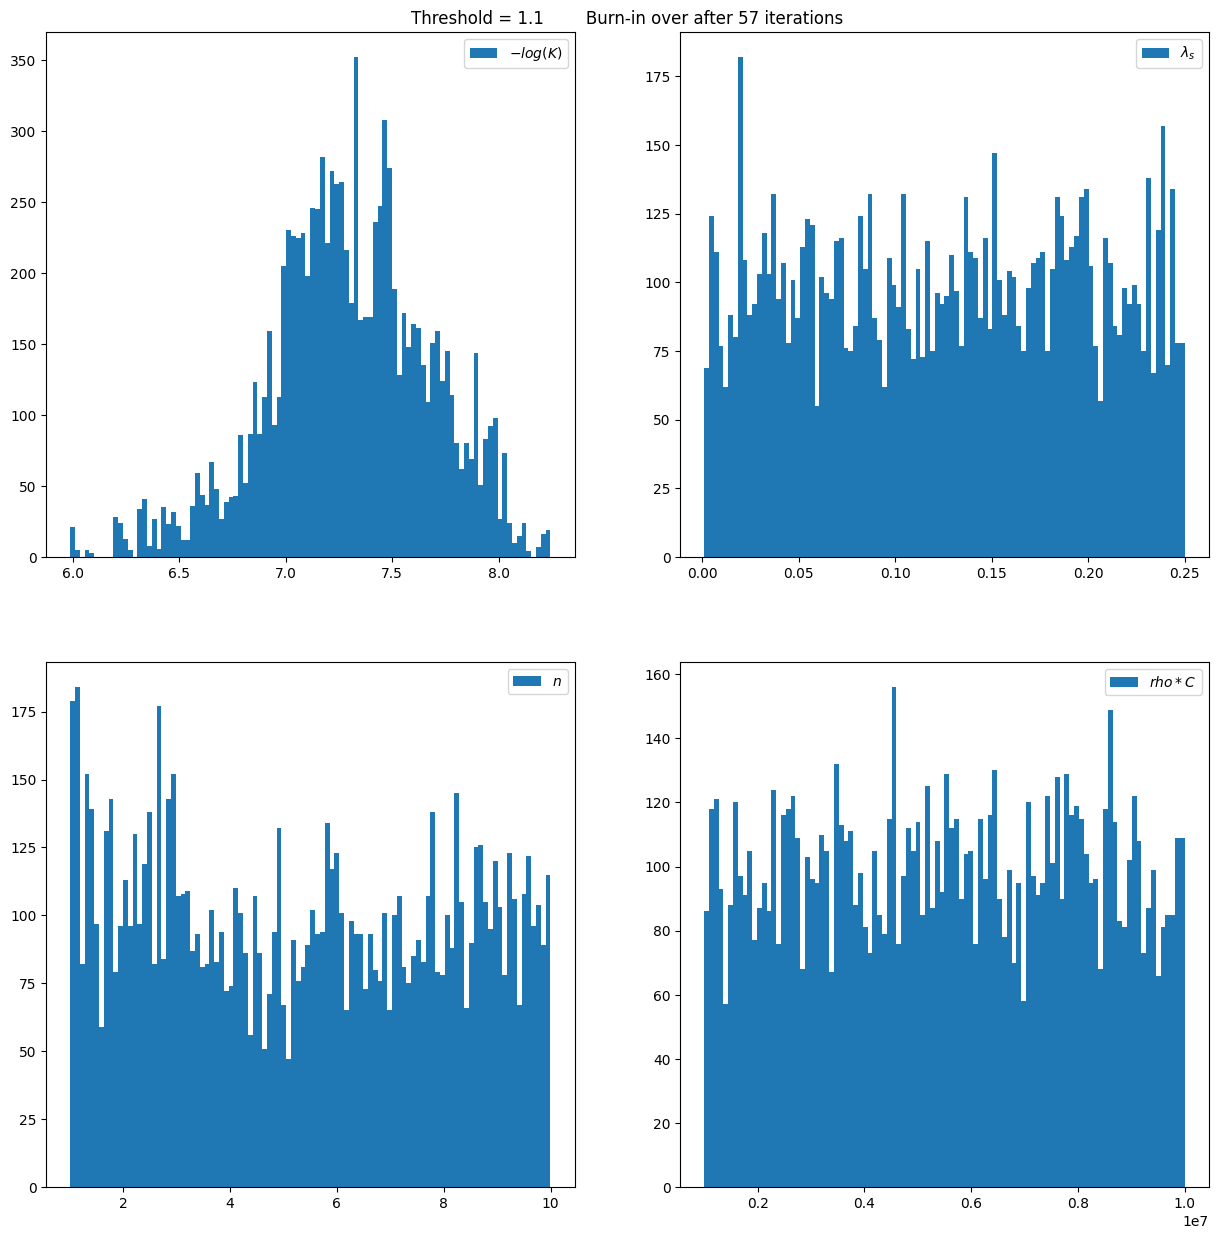

In [25]:
nb_iter, nb_chain, nb_layer, nb_param = _params.shape
_params_without_chains = _params.reshape(nb_iter * nb_chain, nb_layer, nb_param)
plt.figure(figsize=(15,15))
plt.title(f"Threshold = {threshold}        Burn-in over after {nb_burn_in_iter} iterations")
plt.axis('off')
dico = {0 : "$-log(K)$", 1 : "$\lambda_s$", 2 : "$n$", 3 : "$rho * C$"}
for k in range(nb_param):
    plt.subplot(2, 2, k+1)
    plt.hist(_params_without_chains[:,0,k], bins = 100, label=f"{dico[k]}")
    plt.legend();
plt.savefig(f"../images/threshold_{int(threshold*100)}.png")

# Calcul des quantiles

Voilà la façon dont sont calculés les quantiles de température (idem pour le flow) dans le projet.

In [26]:
quantile = np.array([0.05, 0.5, 0.95])
quantiles_temperatures = np.quantile(_temp, quantile, axis=0)

Le calcul est gourmand en temps de calcul et nécessite de stocker un tableau `quantiles_temps` et un tableau `temp` dont les tailles sont indiquées ci-dessous.

In [27]:
print("Dimensions de quantiles_temperatures : ", quantiles_temperatures.shape, " (nb_quantiles, nb_chain, n_cells, n_temperatures)")
print("Dimensions de quantiles_temperatures : ", _temp.shape, " (nb_iter, nb_chain, n_cells, n_temperatures)")

Dimensions de quantiles_temperatures :  (3, 10, 100, 1309)  (nb_quantiles, nb_chain, n_cells, n_temperatures)
Dimensions de quantiles_temperatures :  (1001, 10, 100, 1309)  (nb_iter, nb_chain, n_cells, n_temperatures)


Ces deux tableaux représentent un encombrement mémoire important qui dépasse le seuil fixé par le cahier des charges.

In [28]:
print("Mémoire pour les quantiles de température : ", quantiles_temperatures.nbytes/1000000, " Méga octets.")
print("Mémoire pour les températures : ", _temp.nbytes/1000000000, "Giga octets.")

Mémoire pour les quantiles de température :  31.416  Méga octets.
Mémoire pour les températures :  5.241236 Giga octets.


Pour réduire cet encombrement mémoire, on peut intuitivement supposer que les profils de température ne varient pas énormément entre deux pas de temps consécutifs. On peut donc réaliser un sous-échantillonnage sur les pas de temps afin de calculer les quantiles. De même, on peut réaliser un sous-échantillonnage spatial.

In [29]:
n_sous_ech_time = 2 # 1 mesure considérée par demi-heure
n_sous_ech_space = 4 # 1 mesure considérée tous les 2 cm

_temp_sous_ech = _temp[:,:,::n_sous_ech_space,::n_sous_ech_time]
quantiles_temperatures_sous_ech = np.quantile(_temp_sous_ech, quantile, axis=0)

np.allclose(quantiles_temperatures_sous_ech,  quantiles_temperatures[:, :, ::n_sous_ech_space, ::n_sous_ech_time])

True

Les quantiles sont calculés sur chaque case $(chaine, cellule, temps)$ en utilisant les valeurs obtenues avec les itérations, il est donc normal que ces deux calculs conduisent aux mêmes valeurs de quantiles.

Déterminons alors le nouvel encombrement mémoire :

In [30]:
print("Mémoire pour les quantiles de température : ", quantiles_temperatures_sous_ech.nbytes/1000000, " Méga octets.")
print("Mémoire pour les températures : ", _temp_sous_ech.nbytes/1000000000, "Giga octets.")

Mémoire pour les quantiles de température :  3.93  Méga octets.
Mémoire pour les températures :  0.655655 Giga octets.


## Utilisation de la méthode P2

Tout d'abord, réalisons le calcul des quantiles avec l'algorithme P2 en stockant les données du tableau afin de vérifier si c'est plus rapide ou non que la fonction `np.quantile`.

In [31]:
def P2(p, data):
    """
    Input : p [float] - nombre du quantile que l'on veut estimer (ex: médiane -> p=0.5)
            data [2D float np.array] - jeu de données désordonné

    Output : [float] estimation du p-ième quantile
    """

    # INITIALISATION

    markers = np.sort(data[:5])
    markers_index = np.arange(5)
    desired_index = np.array([1., 1+2*p, 1+4*p, 3+2*p, 5])
    increment = np.array([0, p/2, p, (1+p)/2, 1])

    # ITERATION

    for x in data[5:]:
        # x est l'observable suivante (actuellement avec le tableau data mais à améliorer pour ne rien avoir à stocker)

        # Déterminer l'indice k tel que marker[k] <= x < marker[k+1]
        k = np.searchsorted(markers, x, side='right') - 1

        if k == 0:
            # Ajuster le minimum
            markers[0] = x
        
        elif k == 4:
            # Ajuster le maximum
            markers[4] = x 

        # Incrémenter les positions des markers au-delà de x
        markers_index[k+1:] += 1

        # Incrémenter toutes les positions désirées
        desired_index += increment 

        # Ajuster les markers centraux si nécessaire
        for i in range(1,4):
            d = desired_index[i] - markers_index[i]

            if ( (d >= 1) and (markers_index[i+1] - markers_index[i] > 1) ) or ( (d <= -1) and (markers_index[i-1] - markers_index[i] < -1) ):

                d = int(np.sign(d))

                # P2 formula
                a = d / (markers_index[i+1] - markers_index[i-1])
                b = (markers_index[i] - markers_index[i-1] + d) * (markers[i+1] - markers[i]) / (markers_index[i+1] - markers_index[i])
                c = (markers_index[i+1] - markers_index[i] - d) * (markers[i] - markers[i-1]) / (markers_index[i] - markers_index[i-1])
                q = markers_index[i] + a * (b + c)

                # Ordonnement des markers
                if markers[i-1] <= q <= markers[i+1]:
                    markers[i] = q
                
                else:
                    # Linear formula
                    markers[i] += d * (markers[i+d] - markers[i]) / (markers_index[i+d] - markers_index[i])

                markers_index[i] += d 
        
    # RENVOYER L'APPEOXIMATION DU p-IEME QUANTILE

    return markers[2]


In [32]:
# quantiles_sous_ech_P2 = np.zeros(quantiles_temperatures.shape)
# nb_cells_sous_ech = nb_cells // n_sous_ech_space
# nb_times_sous_ech = _temp.shape[-1] // n_sous_ech_time

# for i,q in enumerate(quantile):
#     for j in range(nb_chain):
#         for c in range(nb_cells_sous_ech):
#             for t in range(nb_times_sous_ech):
#                 tab = _temp_sous_ech
#                 quantiles_sous_ech_P2[i,j,c,t] = P2(q, _temp_sous_ech[:,j,c,t])

C'est très lent, je déconseille d'attendre la fin de l'exécution. On rejette donc immédiatement l'éventualité de remplacer `np.quantile` par P2, bien que ce dernier algorithme ait l'avantage de fonctionner même sans stocker les données dans un tableau. Nous utiliserons uniquement le sous-échantillonnage dans la suite et essayerons deux protocoles dans le but de respecter la contrainte de 2Go de mémoire vive imposée par le cahier des charges.

## Les solutions envisagées

* Ecrire dans un fichier pendant la MCMC pour ne pas encombrer la mémoire de plus de 5Go de données
* Ne pas écrire dans un fichier mais retrouver les distributions de température uniquement avec les quantiles obtenus avec le tableau sous-échantillonné, calculé pendant MCMC.